# 工具与运行时的值

有时，您希望让工具调用LLM填充工具函数参数的子集 ，并在运行时为其他参数提供其他值。核心技术是将参数注释为 “injected”，这意味着它将由您的程序注入，并且不应由 LLM 提供

## 工具访问图形状态

我们希望我们的工具将图形状态作为输入，但我们不希望模型在调用工具时尝试生成此输入。我们可以使用 InjectedState 注解将参数标记为必需的图形状态（或图形状态的某个字段）。这些参数不会由模型生成。使用 ToolNode 时，图形状态将自动传递给相关工具和参数。

在此示例中，我们将创建一个返回 Documents 的工具，然后创建另一个实际引用证明声明合理的 Documents 的工具。

In [1]:
from typing import List, Tuple
from typing_extensions import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import InjectedState


@tool
def get_context(question: str, state: Annotated[dict, InjectedState]):
    """Get relevant context for answering the question."""
    return "\n\n".join(doc for doc in state["docs"])

如果我们查看这些工具的输入架构，我们将看到 state 仍然列出：

In [6]:
from pprint import pprint

pprint(get_context.get_input_schema().model_json_schema())

{'description': 'Get relevant context for answering the question.',
 'properties': {'question': {'title': 'Question', 'type': 'string'},
                'state': {'additionalProperties': True,
                          'title': 'State',
                          'type': 'object'}},
 'required': ['question', 'state'],
 'title': 'get_context',
 'type': 'object'}


但是，如果我们查看工具调用架构，即传递给模型进行工具调用的内容， 则 state 已被删除：

In [7]:
pprint(get_context.tool_call_schema.model_json_schema())

{'description': 'Get relevant context for answering the question.',
 'properties': {'question': {'title': 'Question', 'type': 'string'}},
 'required': ['question'],
 'title': 'get_context',
 'type': 'object'}


## 完整示例

In [8]:
from typing import List

# this is the state schema used by the prebuilt create_react_agent we'll be using below
from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, create_react_agent
from langgraph.checkpoint.memory import MemorySaver

class State(AgentState):
    docs: List[str]

model = ChatOpenAI(
    model="gpt-4o-mini",
)
tools = [get_context]

# ToolNode will automatically take care of injecting state into tools
tool_node = ToolNode(tools)

checkpointer = MemorySaver()
graph = create_react_agent(model, tools, state_schema=State, checkpointer=checkpointer)

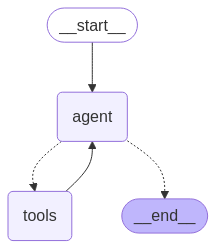

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
docs = [
    "FooBar company just raised 1 Billion dollars!",
    "FooBar company was founded in 2019",
]

inputs = {
    "messages": [{"type": "user", "content": "what's the latest news about FooBar. Before you call a tool, explain why you will call it."}],
    "docs": docs,
}
config = {"configurable": {"thread_id": "1"}}
for chunk in graph.stream(inputs, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the latest news about FooBar. Before you call a tool, explain why you will call it.
================================== Ai Message ==================================

To find the latest news about FooBar, I will call the tool that retrieves relevant context. This will help me access up-to-date information or recent developments related to FooBar. It's essential to use this tool to ensure that the information is accurate and current, especially if there have been recent events or announcements. 

Now, I will proceed with the tool call.
Tool Calls:
  get_context (call_o0F97me0n5oeOpO3NScnk3d5)
 Call ID: call_o0F97me0n5oeOpO3NScnk3d5
  Args:
    question: latest news about FooBar
================================= Tool Message =================================
Name: get_context

FooBar company just raised 1 Billion dollars!

FooBar company was founded in 2019
================================== Ai Messag